# Homework 2

In this homework, you'll get a chance to 

1. Run some numerical experiments with the HH model, 
2. Get a feel for ho to simplify the model to a lower dimension and represent its state 
3. Learn about the idea of _bifurcations_ in a 1D neural model and understand how these mathematical phenomena represent spiking thresholds and dynamics. 

In [ ]:
# Only run this cell on Colab, it downloads the package you need to run code from class 
!wget https://raw.githubusercontent.com/badralbanna/FTN/master/onedim.py
!wget https://raw.githubusercontent.com/badralbanna/FTN/master/ndim.py

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Importing all the functions from class
from onedim import *
from ndim import *

In [24]:
# Setting plotting defaults

# Make legend text small
plt.rcParams['legend.fontsize'] = 'small' 
# Shrink axes labels a bit 
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
# Set limits on when scientific notation is used
plt.rcParams['axes.formatter.limits'] = [-2, 3] 
# Use LaTeX to format axes labels and numbers
plt.rcParams['axes.formatter.use_mathtext'] = True
# Get rid of spines on top and bottom
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Ticks point in  
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# Change DPI of figure images
plt.rcParams['figure.dpi'] = 150

## Question 1: Experimenting with the HH model

In this question, you'll get some practice using the HH model from class.

### 1.1 Implement a simple experiment  

All you need to do for this question is write a function to implement one of the experimental current injections we discussed in class (ramp, sinusoidal, noise) and play around a bit with some of the paramaters (e.g. amplitude, etc.). Take notes on what you see and discuss in the text block below. 

In [25]:
# JUST RUN THIS CELL
# Setting paramaters

## Capacitance (in micro-F/mm^2)
c = 0.010

## Conductances (in mS/mm^2)
gL = 0.003
gK = 0.036
gNa = 1.2

## Reversal potentials (in mV)
eL = -70
eK = -77
eNa = 50

# Membrane voltage dynamics
def dVdt(V, n, m, h, t):
    i_m = gL*(V-eL) + gK*(n**4)*(V-eK) + gNa*(m**3)*h*(V-eNa) 
    return((-i_m + i(t)) / c)

# Voltage-gated channel subunit dynamics

def alpha_n(V):
    return(0.01*(V + 55) / (1 - np.exp(-0.1*(V + 55))))

def beta_n(V):
    return(0.125*np.exp(-0.0125*(V + 65)))

def dndt(V, n):
    delta = alpha_n(V)*(1.0-n) - beta_n(V)*n
    if (delta > 1.-n) or (n>1.):
        delta = 1.-n
    elif (delta < -n) or (n<0):
        delta = -n
    return(delta) 

def alpha_m(V):
    return(0.1*(V + 40) / (1 - np.exp(-0.1*(V + 40))))

def beta_m(V):
    return(4*np.exp(-0.0556*(V + 65)))

def dmdt(V, m):
    delta = alpha_m(V)*(1.0-m) - beta_m(V)*m
    if (delta > 1.-m) or (m>1.):
        delta = 1. - m
    elif (delta < -m) or (m<0.):
        delta = -m
    return(delta) 

def alpha_h(V):
    return(0.07*np.exp(-0.05*(V + 65)))

def beta_h(V):
    return(1 / (1 + np.exp(-0.1*(V + 35))))

def dhdt(V, h):
    delta = alpha_h(V)*(1.0-h) - beta_h(V)*h
    if (delta > 1.-h) or (h>1.):
        delta = 1.-h
    elif (delta < -h) or (h<0.):
        delta = -h
    return(delta) 

# Putting all the dynamics together into one function
def dSdt(V, n, m, h, t):
    return(np.array([dVdt(V, n, m, h, t), dndt(V, n), dmdt(V, m), dhdt(V, h), 1.]))

In [26]:
# EDIT THIS CELL
# Functions defining external current

## Experimental current
def make_sinusoidal_i(t_s, A, T):
    def i_e(t):
        if (t>=t_s):
            return A*np.sin(2*np.pi*t/T)
        else:
            return 0
    return(i_e)

def make_ramping_i(t_s, t_f, i_max):
    def i_e(t):
        if (t>=t_s) & (t<t_f):
            return i_max*(t - t_s)/ (t_f - t_s)
        elif (t>=t_f):
            return i_max
        else:
            return 0
    return(i_e)

from numpy.random import randn 

def make_noise_i(t_s, i_avg, A):
    def i_e(t):
        if (t>=t_s):
            return A*randn() + i_avg
        else:
            return 0
    return(i_e)

# Setting paramaters

## External current function (in micro-A/mm^2)
i = make_ramping_i(20, 100, .05)

In [27]:
# EDIT AS NEEDED AND RUN
## starting values for V, n, m, h, t
S_0 = [-80, 0, 0, 0, 0]

## Final value for T
T_f = 200 # in ms

## Simulating all other time points
S = simulate_nD(S_0, T_f, dSdt, verbose=False)

## Saving out simulation results as individual variables
V = S[:,0]
n = S[:,1]
m = S[:,2]
h = S[:,3]
T = S[:,4]

Text(0.5, 0, 'Time (ms)')

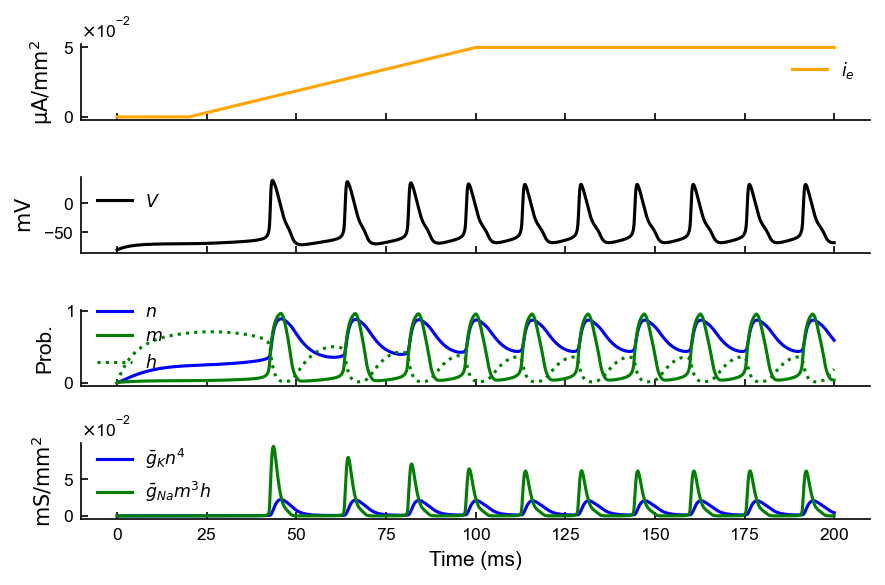

In [28]:
# JUST RUN THIS CELLTO GENERATE PLOTS
fig, (ax_i, ax_v, ax_c, ax_c2) = plt.subplots(nrows=4, sharex=True)

## Plotting current
ax_i.plot(T, [i(t) for t in T], c='orange', label="$i_e$")
ax_i.legend()
ax_i.set_ylabel("$\\mathrm{\mu A}/\\mathrm{mm^2}$")

## Plotting membrane voltage
ax_v.plot(T, V, c='k', label="$V$")
ax_v.legend()
ax_v.set_ylabel("$\\mathrm{mV}$")

## Plotting activation and inactivation gates
ax_c.plot(T, n, c='blue', label="$n$")
ax_c.plot(T, m, c='green', label="$m$")
ax_c.plot(T, h, c='green', ls=':', label="$h$")
ax_c.legend()
ax_c.set_ylabel("Prob.")

## Plotting conductances
ax_c2.plot(T, gK*n**4, c='blue', label="$\\bar{g}_{K} n^4$")
ax_c2.plot(T, gNa*m**3*h, c='green', label="$\\bar{g}_{Na} m^3h$")
ax_c2.legend()
ax_c2.set_ylabel("$\\mathrm{mS}/\\mathrm{mm}^2$")

ax_c2.set_xlabel("Time (ms)")

In [29]:
# RUN THIS CELL, YOU CAN USE THIS FUNCTION TO FIND TIMES OF ACTION POTENTIALS
# Function to find action potential times
from scipy.signal import find_peaks

def AP_times(V, T, dt=DT):
    return(T[find_peaks(V, height=0, width=int(1./dt))[0]])

In [30]:
AP_times(V, T)

array([ 43.3,  64.2,  81.9,  98. , 113.7, 129.4, 145. , 160.7, 176.4,
       192. ])

In [31]:
# Code block if needed

**Discuss your results here**

### 1.2 Derive the firing rate vs. injected current curve for a HH neuron

Now we'd like to do something a bit more systematic with our HH neuron, namely find the firing rate versus the amplitude of injected current. As we discussed briefly in class, there is a current below which the cell will never fire (the _rheobase_) but above that value the cell will fire and increase its firing rate as teh injected current increases. The question is what happens at the transition from not-firing to firing: does it smoothly rise from a firing rate of 0 or is there a sudden jump? This is a key distinction of the behavior of so-called Type I neurons and Type II neurons that goes along with many other important differences. 

In [33]:
# EDIT THE CELL BELOW TO RUN THE EXPERIMENT FOR THE VALUES IN `i_max_values` AND
# SAVE FIRING RATES TO `firing_rates`

def make_step_i(t_s, t_f, i_max):
    def i_e(t):
        if (t>=t_s) & (t<t_f):
            return i_max
        else:
            return 0
    return(i_e)

i_max_values = np.linspace(0.0, 0.05, 40)
firing_rates = [] # this is the list to collect the firing rates
T_f = 420 # trial length is 20 ms to stabilize plus 200 ms of current 

for i_max in i_max_values:
    i = make_step_i(20, T_f, i_max)
    S_0 = [-80, 0, 0, 0, 0]
    S = simulate_nD(S_0, T_f, dSdt)
    V = S[:,0]
    T = S[:,4]
    spike_times = AP_times(V, T)
    firing_rate = len(spike_times) / ((T_f - 20)*0.001)
    firing_rates.append(firing_rate)
    
print(firing_rates)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 25.0, 30.0, 32.5, 35.0, 37.5, 37.5, 40.0, 42.5, 42.5, 45.0, 45.0, 47.5, 47.5, 50.0, 50.0, 52.5, 52.5, 52.5, 55.0, 55.0, 55.0, 57.5, 57.5, 57.5, 60.0, 60.0, 60.0, 60.0, 62.5, 62.5, 62.5, 62.5, 65.0]


Text(0.5, 0, 'Injected current ($\\mu \\mathrm{A}$/$\\mathrm{mm}^2$)')

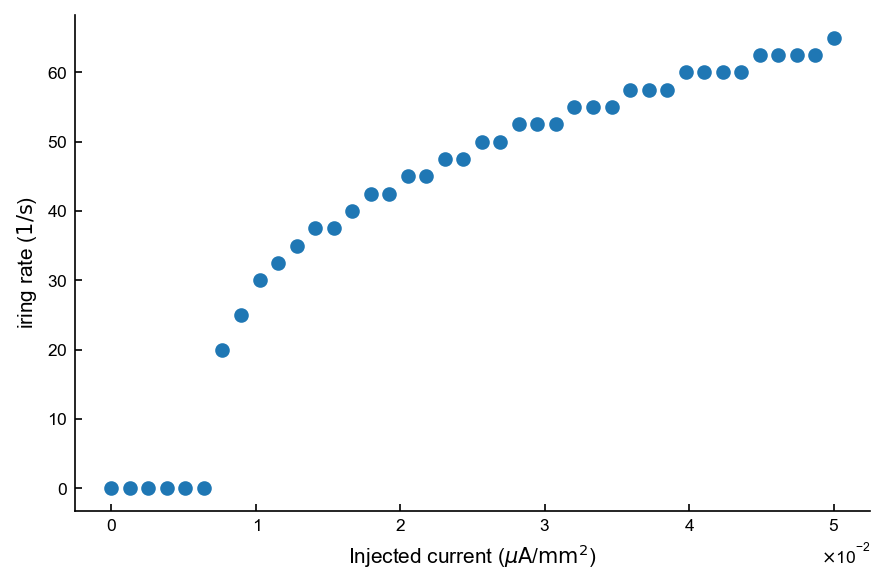

In [34]:
# EDIT TO MAKE A SCATTER PLOT OF FIRING RATE VERSUS CURRENT (MAKE SURE TO LABEL AXES ETC)
fig, ax = plt.subplots()
ax.scatter(i_max_values, firing_rates)
ax.set_ylabel("iring rate ($1/\mathrm{s}$)")
ax.set_xlabel("Injected current ($\mu \mathrm{A}$/$\mathrm{mm}^2$)")

**According to your plot, roughly where is the rheobase (min current to fire) for out HH neuron?**



approximately 0.06 microAmps per mm sqaured. 

**According to your plot, discuss whether the HH model with standard paramaters is a Type I (smooth rise) or Type II (sudden jump) neuron**

Type II since the jump appears to be discontinuous.

## Question 2: Simplifying the HH model

In this problem I'd like you to simplify the 4D HH model to something similar using the methods we described in class. 

In class we observed that $n(t)$ and $h(t)$ are highly correlated in the model. Specifically we found that 

$$h = -0.906 n + 0.776$$

Moreover we argued that we should be able to replace $m(t)$ with its asymptotic values $m_\infty(V)$. These two replacements would make our 4D model (+ time) into a 2D model (+ time). 

In a 2D neural model with $V$ and one other variable. The other variable is referred to as the _recovery variable_. In our simplified model $n$ is the recovery varible.

_(Note: The numerical stability may not be the same as the original HH model so you may need to tweak the simulation timestep `dt` when you run `simulate` in order to get this to work)_

### 2.1 Changing the dynamics

In [35]:
# COMPLETE `dVdt_simple` BELOW
# Setting paramaters

## Capacitance (in micro-F/mm^2)
c = 0.010

## Conductances (in mS/mm^2)
gL = 0.003
gK = 0.036
gNa = 1.2

## Reversal potentials (in mV)
eL = -70
eK = -77
eNa = 50

def alpha_m(V):
    return(0.1*(V + 40) / (1 - np.exp(-0.1*(V + 40))))

def beta_m(V):
    return(4*np.exp(-0.0556*(V + 65)))

# Asymptotic form for m
def m_inf(V):
    return(alpha_m(V) / (alpha_m(V) + beta_m(V)))

# def h(n):
#     h_val = -0.906*n + 0.776
#     if h_val >= 0.5:
#         return .5
#     elif h_val <= 0.1:
#         return 0.1
#     else:
#         return h_val

# Membrane voltage dynamics
## COMPLETE THIS EQUATION 
def dVdt_simple(V, n, t):
    i_m = gL*(V-eL) + gK*(n**4)*(V-eK) + gNa*(m_inf(V)**3)*(-0.906*n + 0.776)*(V-eNa) 
    return((-i_m + i(t)) / c)

# # Voltage-gated channel subunit dynamics for n
def alpha_n(V):
    return(0.01*(V + 55) / (1 - np.exp(-0.1*(V + 55))))

def beta_n(V):
    return(0.125*np.exp(-0.0125*(V + 65)))

def dndt(V, n):
    delta = alpha_n(V)*(1.0-n) - beta_n(V)*n
    if (delta > 1.-n) or (n>1.):
        delta = 1.-n
    elif (delta < -n) or (n<0):
        delta = -n
    return(delta)

# Putting all the dynamics together into one function
def dSdt_simple(V, n, t):
    return(np.array([dVdt_simple(V, n, t), dndt(V, n), 1.]))

## External current function (in micro-A/mm^2)
i = make_ramping_i(20, 200, .2)

### 2.2. Simulate the result

Simulate the new simplified model using the same experiment you show in **1.1** for the full model. 

In [41]:
# EDIT AS NEEDED AND RUN
## starting values for V, n, t
S_0_simple = [-80, 0, 0]

## Final value for T
T_f = 200 # in ms

## Simulating all other time points using our simpler dynamics
S = simulate_nD(S_0_simple, T_f, dSdt_simple, dt=.01)

## Saving out simulation results as individual variables
V = S[:,0]
n = S[:,1]
T = S[:,2]

Text(0.5, 0, 'Time (ms)')

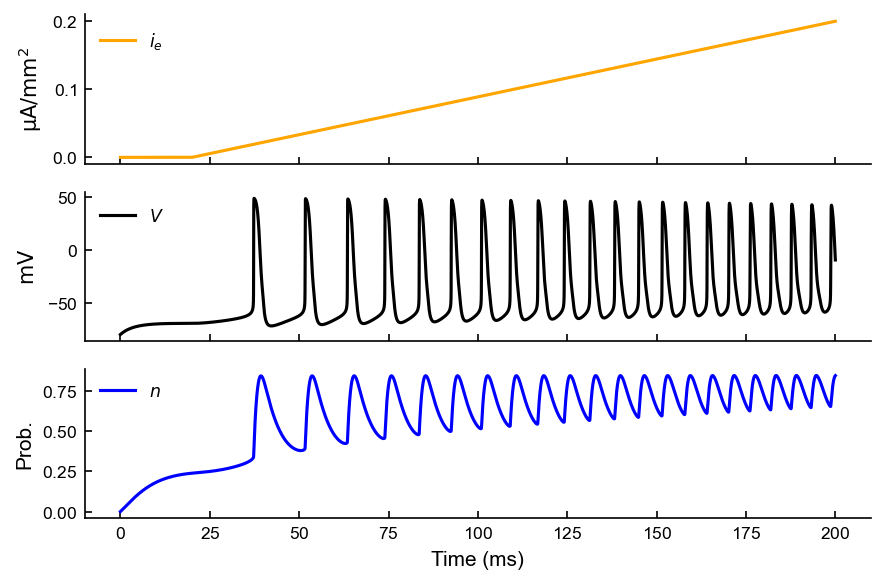

In [42]:
# JUST RUN THIS CELL TO GENERATE PLOTS fOR SIMPLIFIED MODEL
fig, (ax_i, ax_v, ax_n) = plt.subplots(nrows=3, sharex=True)

## Plotting current
ax_i.plot(T, [i(t) for t in T], c='orange', label="$i_e$")
ax_i.legend()
ax_i.set_ylabel("$\\mathrm{\mu A}/\\mathrm{mm^2}$")

## Plotting membrane voltage
ax_v.plot(T, V, c='k', label="$V$")
ax_v.legend()
ax_v.set_ylabel("$\\mathrm{mV}$")

## Plotting recorvery variable
ax_n.plot(T, n, c='blue', label="$n$")
ax_n.legend()
ax_n.set_ylabel("Prob.")

ax_n.set_xlabel("Time (ms)")

**Discuss your reduced model in coparison to the full model above**

### 2.3 Plotting the n, V phase plane

In the next two weeks we'll be looking at a lot of 2D phase planes. Plot the trajectory of your solution in 2D with $n$ vs. $V$.

In [ ]:
## MAKE APLOT FROM SCRATCH OF N VERSUS V (LABEL AXES, ETC.)



**Discuss what the trajectory does in the phase plane as the neuron is spiking.**

## Question 3: bifurcations and bistability in a simple 1D neuron model

In the coming two weeks we'll talk about how 2D models go from "sitting at rest" to "spiking" as the current increases. In the language of dynamical systems, the stable critical point at rest becomes unstable as the current is increased. This is what is referred as a _bifurcation_. 

To get at this idea, we'll consider a very simplified 1D model for a neuron with only a leak current, and a fast Na channel. This neuron will simulate the upswing of the action potential. In addition to exhibiting a _bifurcation_ as the current increase it will be _bistable_ in that it permits to stable critical points: rest and "firing". 

The equation for this simple model is as follows:

$$c_m \frac{dV}{dt} = - g_L (V - E_L) - \bar{g}_{Na} m_\inf (V) (V - E_{Na}) + I$$

For a rat pyramidal neuron the following values apply

$$c_m = 0.010\;\textrm{mF}$$

$$g_L = 0.19\;\textrm{mF}, E_L=-67\;\textrm{mV}$$

$$\bar{g}_{Na} = 0.74\;\textrm{mF}, E_{Na}= 60\;\textrm{mV}$$

and 

$$m_\inf(V) = \frac{1}{1 + \exp((V_{1/2} - V) / k)}$$

where 

$$V_{1/2}=1.5\;\textrm{mV}, k=16\;\textrm{mV}$$. 

### 3.1 Plot $\frac{dV}{dt}$ when $i = 0$, discuss dynamics

In [81]:
c = 0.10
g_L = 0.19
E_L = -67
g_Na = 0.74
E_Na = 60

V12 = 1.5
k = 16

# WRITE FUNCTIONS FOR `m_inf(V)` and `dVdt(V)`
def m_inf(V):
    return(1 / (1 + np.exp((V12 - V)/k)))

def dVdt(V):
    i_m = g_L*(V - E_L) + g_Na*m_inf(V)*(V - E_Na)
    return((-i_m + i)/c)

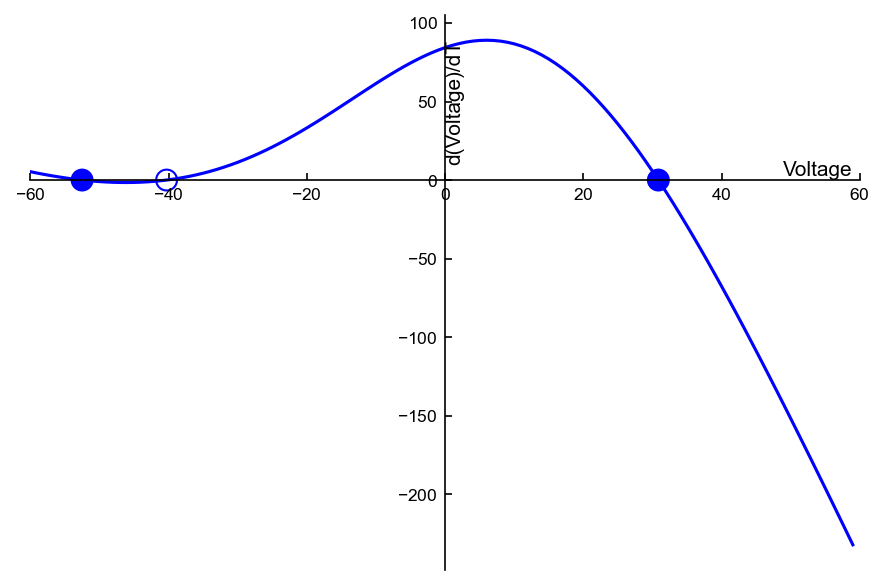

In [84]:
# JUST RUN THIS CELL TO MAKE A PLOT OF THE PHASE SPACE FOR THIS SYSTEM
i = 0

plot_1D_phase_space(dVdt, xlim=(-60, 60), x_label="Voltage", res_c=1)

### 3.2 Discuss what you see in the phase space

What do the two stable critical points represent here (in the terms that we use to talk about real neurons)? What happens to cells that start with a membrane voltage below the unstable critical point? What about those that start above? What does the unstable critical point that seperates the two stable points represent in the terms that we use to talk about real neurons).

**Put your answer here. Feel free to render any other figures you like using the 1D simulations functions (these have already been loaded into this notebook)**

### 3.3 What happens when $i$ increases? 

How does this picture change as $i$ increases? at what value for $i$ will you see a _qualititative_ change in the dynamics (i.e. critical points appear/dissapear = a bifurcation). How would a cell behave if $i$ is held above this value? What if it is held above this value for a period and then dropped back to $i=0$?

**Put your answer here. Feel free to render any other figures you like using the 1D simulations functions (these have already been loaded into this notebook)**